In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/UNIVERSITY/deep-learning-classifier-model/src

/content/drive/MyDrive/UNIVERSITY/deep-learning-classifier-model/src


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import os
import copy
import time

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

data_dir = '../data/train'

full_dataset = datasets.ImageFolder(data_dir, data_transforms['train'])
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=0)
class_names = full_dataset.classes
dataloaders = {'train': train_loader, 'val': val_loader}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(class_names)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Define dataset_sizes
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

['Honda', 'Perodua', 'Proton', 'Toyota']


In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'train_aug': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

train_dataset = datasets.ImageFolder(data_dir, data_transforms['train'])
train_aug_dataset = datasets.ImageFolder(data_dir, data_transforms['train_aug'])
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_aug_dataset, _ = random_split(train_aug_dataset, [train_size, val_size])
train_dataset = torch.utils.data.ConcatDataset([train_dataset, train_aug_dataset])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=0)

print(len(train_dataset) + len(val_dataset))


1069


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            else:
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
# HYPERPARAMETERS

LEARNING_RATE = 0.001
MOMENTUM = 0.9
STEP_SIZE = 5
GAMMA = 0.1
NUM_EPOCHS = 11
# CONSTANT = 20


In [ ]:
model = models.resnet18(pretrained=True)
#model = models.resnet18(weights='imagenet')

num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=NUM_EPOCHS)

model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=STEP_SIZE, gamma=GAMMA)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=NUM_EPOCHS + CONSTANT)



Epoch 0/10
----------
train Loss: 1.3217 Acc: 0.3705
val Loss: 1.2823 Acc: 0.4444

Epoch 1/10
----------
train Loss: 1.0571 Acc: 0.5773
val Loss: 1.1541 Acc: 0.5503

Epoch 2/10
----------
train Loss: 0.9447 Acc: 0.6136
val Loss: 1.0467 Acc: 0.5291

Epoch 3/10
----------
train Loss: 0.8458 Acc: 0.6818
val Loss: 1.0972 Acc: 0.5079

Epoch 4/10
----------
train Loss: 0.7254 Acc: 0.7114
val Loss: 1.0522 Acc: 0.5291

Epoch 5/10
----------
train Loss: 0.6305 Acc: 0.7636
val Loss: 1.0218 Acc: 0.5661

Epoch 6/10
----------
train Loss: 0.5816 Acc: 0.7818
val Loss: 1.0318 Acc: 0.6085

Epoch 7/10
----------
train Loss: 0.4860 Acc: 0.8023
val Loss: 0.9280 Acc: 0.6720

Epoch 8/10
----------
train Loss: 0.4788 Acc: 0.8182
val Loss: 0.8825 Acc: 0.6667

Epoch 9/10
----------
train Loss: 0.4539 Acc: 0.8273
val Loss: 0.8266 Acc: 0.7037

Epoch 10/10
----------
train Loss: 0.4455 Acc: 0.8386
val Loss: 0.7427 Acc: 0.6561

Training complete in 23m 31s
Best val Acc: 0.703704
Epoch 0/10
----------
train Loss: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torchvision/datasets/folder.py", line 248, in pil_loader
    return img.convert("RGB")
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 937, in convert
    self.load()
  File "/usr/local/lib/python3.10/dist-packages/PIL/ImageFile.py", line 249, in load
    s = read(self.decodermaxblock)
  File "/usr/local/lib/python3.10/dist-packages/PIL/PngImagePlugin.py", line 980, in load_read
    return self.fp.read(read_bytes)
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-c69765575df9>", line 40, in <cell line: 40>
    model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, n

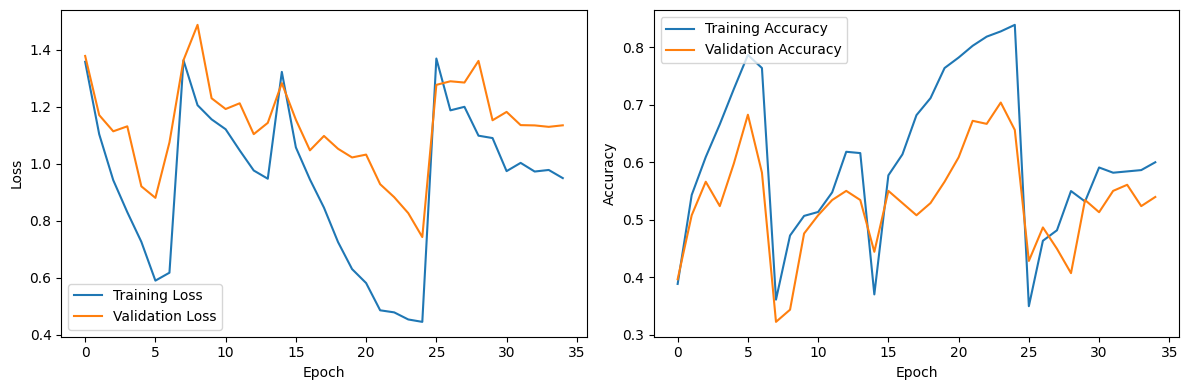

In [ ]:
# After training, plot the training and validation loss/accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
